In [1]:
#Imporing supporting libraries
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from PIL import Image

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.densenet import DenseNet121

from keras.layers import Input
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import Model
from keras import backend as K

from time import time
import pickle
from pickle import dump, load
import glob
import os
from random import shuffle
import importlib
from configparser import ConfigParser
from nltk.translate.bleu_score import sentence_bleu

Using TensorFlow backend.
C:\Users\IC016726\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\IC016726\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\IC016726\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\IC016726

In [2]:
#Load the pre processed report findings from the pickle file.
first_sent = load(open("KalyanPickle/para.pickle", "rb"))
print('Photos: train=%d' % len(first_sent))

Photos: train=3668


In [4]:
#Load the pre processed report Indication from the pickle file.
indication_sent = load(open("KalyanPickle/indication_keys.pickle", "rb"))
print('Photos: train=%d' % len(indication_sent))

Photos: train=3668


In [6]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    """
        **Convert descriptions to  vocabulary**
        
        This function will create vocabulary using descriptions
        
        :param descriptions: image to report key-value pairs
        :type descriptions: dict
        :return: set of unique words of all descriptions - vocabulary
        
        - Example::

            descriptions - {'CXR1_1_IM-0001-3001': ['startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq'],
 'CXR10_IM-0002-1001': ['startseq the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. . endseq']
                            }
                            
            to_vocabulary(descriptions)
            
        - Expected Success Response::

            {'startseq',
            'the',
            'cardiac',
            ...
            'endseq'
            }
    
    """
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(first_sent)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 2311


In [7]:
# vocabulary of words in report indication 
all_indications = set()
for key in indication_sent.keys():
    all_indications.update(indication_sent[key].split())
indicationVocab = all_indications
print('Original Vocabulary Size: %d' % len(indicationVocab))

Original Vocabulary Size: 1572


In [8]:
# Below path contains all the images
images = 'NLMCXR_png/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.png')

In [10]:
# Split the images into test and train. have split into 90:10 ratio
train_img_paths = img[:int(len(img)*0.90)]
valid_img_paths = img[int(len(img)*0.70 + len(img)*0.20):]

In [11]:
print("No of images for training: ", len(train_img_paths))
print("No of images for validating: ", len(valid_img_paths))

No of images for training:  6546
No of images for validating:  728


In [19]:
def get_train_valid_test_data(img):
    """
        **Splits images into test and train sets of ratio 90:10**
        
        This function will create test and train sets of ratio 90:10 with given image sets
        
        :param img: image to split
        :type img: array
        :return: set of images for training and testing
        
        - Example::

            img - ['NLMCXR_png\\CXR1000_IM-0003-1001.png',
                   'NLMCXR_png\\CXR1000_IM-0003-2001.png',........
                   'NLMCXR_png\\CXR1000_IM-0003-3001.png']
                            
            train_imgs, valid_imgs = get_train_valid_test_data(img)
            
        - Expected Success Response::

            train_imgs - ['NLMCXR_png\\CXR1000_IM-0003-1001.png',
                          'NLMCXR_png\\CXR1000_IM-0003-2001.png',
                          'NLMCXR_png\\CXR1000_IM-0003-3001.png',......
                          'NLMCXR_png\\CXR1001_IM-0004-1001.png']
            valid_imgs - ['NLMCXR_png\\CXR614_IM-2200-1001.png',
                          'NLMCXR_png\\CXR614_IM-2200-4001.png',
                          'NLMCXR_png\\CXR615_IM-2200-1001.png',
                          'NLMCXR_png\\CXR615_IM-2200-1002.png',.......
                          'NLMCXR_png\\CXR616_IM-2200-1001.png']
    
    """
    train_imgs = img[:int(len(img)*0.90)]
    valid_imgs = img[int(len(img)*0.70 + len(img)*0.20):]
    return train_imgs, valid_imgs

In [20]:
train_imgs, valid_imgs = get_train_valid_test_data(img)

In [22]:
weights_path = "PavanPickle/best_weights.h5"

In [23]:
class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
                        NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_model(self, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):
        """
        **Provides the requested CNN pre trained model**
        
        This function provides the requested CNN pre trained model
        
        :param model_name: pre trained model name
        :type model_name: string
        
        :param use_base_weights: Indicates to use the base weights or not
        :type use_base_weights: bool
        
        :param weights_path: location path where the weigths are present
        :type weights_path: string
        
        :param input_shape: shape of the input image to the pretrained model
        :type input_shape: array
        
        :return: Pretrained CNN Model
        
        - Example::
        
            weights_path = "PavanPickle/best_weights.h5"
            
            model = model_factory.get_model(use_base_weights=False,weights_path=weights_path)
            
        - Expected Success Response::
            model
    
        """
        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(14, activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None
        

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [24]:
model_factory = ModelFactory()
model = model_factory.get_model(
    use_base_weights=False,
    weights_path=weights_path)
print(model.summary())









load model weights_path: PavanPickle/best_weights.h5
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________

In [31]:
def load_image(image_path):
        """
        **Loads the Image from the provided path**
        
        This function will loads the image from the provided path
        
        :param image_path: path of the image files
        :type image_path: string
        :return: Image
        :type Image: array
        
        - Example::

            img - ['NLMCXR_png\\CXR1000_IM-0003-1001.png',
                   'NLMCXR_png\\CXR1000_IM-0003-2001.png',........
                   'NLMCXR_png\\CXR1000_IM-0003-3001.png']
                            
            imgs = load_image(img)
            
        - Expected Success Response::

            image
    
        """
        image = Image.open(image_path)
        image_array = np.asarray(image.convert("RGB"))
        image_array = image_array / 255.
        image_array = np.resize(image_array, (1,224,224,3))
        return image_array

In [32]:
def get_img_encoding(img):
    """
        **Provides the Image encoding for the given image**
        
        This function will provides the Image encoding for the given image
        
        :param img: Imput image to get the encoding
        :type descriptions: array
        :return: Image encoding
        :type: array
        
        - Example::

            sample_img_encoding = get_img_encoding(img[0])
            sample_img_encoding.shape
            
        - Expected Success Response::

            (1024,)
    
    """
    img = load_image(img)
    get_last_but_one_layer_output = K.function([model.layers[0].input],
                                        [model.layers[-2].output])
    layer_output = get_last_but_one_layer_output([img])
    return layer_output[0].squeeze()

In [33]:
sample_img_encoding = get_img_encoding(img[0])

In [34]:
sample_img_encoding.shape

(1024,)

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_imgs:
    encoding_train[img[len(images):]] = get_img_encoding(img)
print("Time taken in seconds =", time()-start)

In [ ]:
import pickle
# Save the bottleneck train features to disk
with open("PavanPickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in valid_imgs:
    encoding_test[img[len(images):]] = get_img_encoding(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck train features to disk
with open("PavanPickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [35]:
#load the saved training image feature
train_features = load(open("PavanPickle/encoded_Moretrain_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6546


In [36]:
#load the saved test image feature
encoding_test = load(open("PavanPickle/encoded_Lesstest_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_test))

Photos: train=728


In [37]:
# Create a list of all the training captions
all_captions = []
for key, val in first_sent.items():
    for cap in val:
        all_captions.append(cap)
len(all_captions)

3668

In [38]:
# Create a list of all the training indications
all_indications = []
for key, val in indication_sent.items():
    all_indications.append(val)
len(all_indications)

3668

In [40]:
# load clean descriptions into memory
def load_clean_descriptions(desc, dataset):
    """
        **Loads the findings which are all available for the trainging images**
        
        This function will load the findings which are all available for the trainging images
        
        :param desc: report findings
        :type desc: dict
        :param dataset: trainning images
        :type desc: list
        :return: findings available for the trainning images
        :type: dict
        
        - Example::
                            
            train_descriptions = load_clean_descriptions(first_sent, dataset)
            print('Descriptions: train=%d' % len(train_descriptions))
            
        - Expected Success Response::

            Descriptions: train=3218
    
    """
    descriptions = dict()
    for key, val in desc.items():
        image_id, image_desc = key, val
        image_id = image_id+'.png'
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = ''.join(image_desc)
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [41]:
len(train_imgs)

6546

In [42]:
dataset = list()
for trimg in train_features:
    dataset.append(trimg)

In [43]:
  len(dataset)

6546

In [45]:
# get the train description
train_descriptions = load_clean_descriptions(first_sent, dataset)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=3218


In [46]:
# get the train indication
train_indications = load_clean_descriptions(indication_sent, dataset)
print('Descriptions: indication=%d' % len(train_indications))

Descriptions: indication=3218


In [47]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

3218

In [48]:
# Create a list of all the training captions
all_train_indications = []
for key, val in train_indications.items():
    for cap in val:
        all_train_indications.append(cap)
len(all_train_indications)

3218

In [50]:
# Consider only words which occur at least 1 times in the corpus
word_count_threshold = 1
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 2216 -> 2216


In [51]:
# Consider only words which occur at least 1 times in the corpus
indication_count_threshold = 1
indication_counts = {}
nsents = 0
for sent in all_train_indications:
    nsents += 1
    for w in sent.split(' '):
        indication_counts[w] = indication_counts.get(w, 0) + 1

indicationVocab = [w for w in indication_counts if indication_counts[w] >= indication_count_threshold]
print('preprocessed words %d -> %d' % (len(indication_counts), len(indicationVocab)))

preprocessed words 1450 -> 1450


In [54]:
#Generate word to index and index to words mapping for text available in findings 
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [55]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
#vocab_size = 2019
vocab_size

2217

In [56]:
#Generate word to index and index to words mapping for text available in indications 
ixtoindicationWord = {}
indicationWordtoix = {}

ix = 1
for w in indicationVocab:
    indicationWordtoix[w] = ix
    ixtoindicationWord[ix] = w
    ix += 1

In [57]:
IndicationVocab_size = len(ixtoindicationWord) + 1 # one for appended 0's
IndicationVocab_size

1451

In [59]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    """
        **Extracts all the findings from the input dictionary of findings**
        
        This function will create list of findings
        
        :param descriptions: image to report key-value pairs
        :type descriptions: dict
        :return: list of findings in report
        
        - Example::

            descriptions - {'CXR1_1_IM-0001-3001': ['startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq'],
 'CXR10_IM-0002-1001': ['startseq the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. . endseq']
                            }
                            
            lines = to_lines(descriptions)
            print(len(lines))
            
        - Expected Success Response::

            172
    
    """
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    """
        **Provides the Maximum length of findings available in trainning set**
        
        This function will provide the Maximum length of findings available in trainning set
        
        :param descriptions: image to report key-value pairs
        :type descriptions: dict
        :return: list of findings in report
        :type : int
        - Example::

            train_descriptions - {'CXR1_1_IM-0001-3001': ['startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq'],
 'CXR10_IM-0002-1001': ['startseq the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. . endseq']
                            }
                            
            max_length = max_length(train_descriptions)
            print('Description Length: %d' % max_length)
            
        - Expected Success Response::

            Description Length: 172
    
    """
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 172


In [60]:
# gets all the indications from the trainning set 
all_Indication_desc = list()
for key in train_indications.keys():
    for d in train_indications[key]:
        all_Indication_desc.append(d)

In [61]:
#gets the maximum length of indication in the report
max_Indication_length = max(len(d.split()) for d in all_Indication_desc)
max_Indication_length

40

In [62]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, num_photos_per_batch):
    """
        **Prepares the input and output data for trainning the model.**
        
        This function will Prepare the input and output data for trainning the model
        
        :param descriptions: image to report key-value pairs
        :type descriptions: dict
        :param photos: Encoded trainning image
        :type photos: array
        :param indications: Indication from trainning report
        :type indications: dict
        :param wordtoix: word to index for findings
        :type indications: list
        :param indicationWordtoix: word to index for indication
        :type indications: list
        :param max_Indication_length: maximum lenght of indication
        :type max_Indication_length: int
        :param max_length: maximum lenght of findings
        :type max_length: int
        :param num_photos_per_batch: number of photos for batch processing
        :type num_photos_per_batch: int
        :return: Input 1, Input 2, Input 3 and output
        :type X1, X2, X3, y: array
        
        - Example::

            generator = data_generator(train_descriptions, train_features,train_indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
            newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
                
    """
    X1, X2, X3, y = list(), list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for indication in indications[key]:
                indicationSeq = [indicationWordtoix[word] for word in indication.split(' ') if word in indicationWordtoix]
            indicationSeq = pad_sequences([indicationSeq], maxlen=max_Indication_length)[0]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(indicationSeq)
                    X3.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2), array(X3)], array(y)]
                X1, X2, X3, y = list(), list(), list(), list()
                n=0

In [41]:
# install gensim for word embeddings
!pip install gensim

In [0]:
from gensim.models import KeyedVectors

In [0]:
word_vectors = KeyedVectors.load_word2vec_format('WordEmbeddings\BioWordVec_PubMed_MIMICIII_d200.vec.bin',binary=True)

In [0]:
medic_vector = word_vectors.get_vector('clinical')

In [0]:
embeddings_index = {} # empty dictionary
i = 0
for item in word_vectors.vocab:
    word = item
    coefs = np.asarray(word_vectors.get_vector(word), dtype='float32')
    embeddings_index[word] = coefs
    i+=1
print('Found %s word vectors.' % len(embeddings_index))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-151827be9c07>", line 3, in <module>
    for item in word_vectors.vocab:
NameError: name 'word_vectors' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-packages/IPython/c

NameError: ignored

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
indication_embedding_matrix = np.zeros((IndicationVocab_size, embedding_dim))

for word, i in indicationWordtoix.items():
    #if i < max_words:
    indicationembedding_vector = embeddings_index.get(word)
    if indicationembedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        indication_embedding_matrix[i] = indicationembedding_vector

In [ ]:
# Save the wordembedding to disk
with open("WordEmbeddings/MoreEmbedding_matrix.pkl", "wb") as embedding_matrix_pickle:
    pickle.dump(embedding_matrix, embedding_matrix_pickle)

In [67]:
#load the saved wordEmbeddings
embedding_matrix = load(open("WordEmbeddings/MoreEmbedding_matrix.pkl", "rb"))

In [68]:
embedding_matrix.shape

(2217, 200)

In [ ]:
# Save the wordembedding of indication to disk
with open("WordEmbeddings/More_Indication_matrix.pkl", "wb") as indication_embedding_matrix_pickle:
    pickle.dump(indication_embedding_matrix, indication_embedding_matrix_pickle)

In [69]:
indication_embedding_matrix = load(open("WordEmbeddings/More_Indication_matrix.pkl", "rb"))

In [70]:
indication_embedding_matrix.shape

(1451, 200)

In [71]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [74]:
#Model architecture
imageFeature = Input(shape=(1024,)) # Input 1 image of size (1024,)
indication = Input(shape=(max_Indication_length,)) # Input 2 report indications
indication1 = Embedding(IndicationVocab_size, embedding_dim)(indication)
indication2 = Flatten()(indication1)
imgIndi = keras.layers.concatenate([imageFeature, indication2],axis=1)# concatenate input image feature and indication
fe1 = Dropout(0.5)(imgIndi)
fe2 = Dense(256, activation='relu')(fe1)
findings = Input(shape=(max_length,)) # Input 3 Sequence of findings
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(findings)
se2 = Dropout(0.5)(se1)
# se3 = LSTM(256, return_sequences=True,return_state=True)(se2)
# se4, hs3, cs3 = LSTM(256,return_state=True)(se3)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2) # Bidirectional LSTMs instantiation
se4 = LSTM(256)(se3)
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)# decoder output
newModel = Model(inputs=[imageFeature, indication, findings], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [75]:
newModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      290200      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 172)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024)         0                                            
____________________________________________________________________________________________

In [76]:
newModel.layers[1]

In [77]:
newModel.layers[5]

In [78]:
newModel.layers[1].set_weights([indication_embedding_matrix]) # assign the indication matrix and do not train it
newModel.layers[1].trainable = False

In [79]:
newModel.layers[5].set_weights([embedding_matrix]) # assign the findings matrix and do not train it
newModel.layers[5].trainable = False

In [80]:
newModel.compile(loss='categorical_crossentropy', optimizer='adam')

In [81]:
newModel.optimizer.lr = 0.0001
epochs = 50
number_pics_per_bath = 5
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features,train_indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
    newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    newModel.save_weights('MoreModelWeights/model_' + str(i) + '.h5')



Epoch 1/1
643/643 [==============================] - 934s 1s/step - loss: 5.0598
Epoch 1/1
643/643 [==============================] - 930s 1s/step - loss: 4.0027
Epoch 1/1
643/643 [==============================] - 928s 1s/step - loss: 3.5127
Epoch 1/1
643/643 [==============================] - 926s 1s/step - loss: 3.2115
Epoch 1/1
643/643 [==============================] - 929s 1s/step - loss: 2.9902
Epoch 1/1
643/643 [==============================] - 924s 1s/step - loss: 2.8236
Epoch 1/1
643/643 [==============================] - 921s 1s/step - loss: 2.6895
Epoch 1/1
643/643 [==============================] - 923s 1s/step - loss: 2.5766
Epoch 1/1
643/643 [==============================] - 921s 1s/step - loss: 2.4781
Epoch 1/1
643/643 [==============================] - 924s 1s/step - loss: 2.3919
Epoch 1/1
643/643 [==============================] - 921s 1s/step - loss: 2.3152
Epoch 1/1
643/643 [==============================] - 924s 1s/step - loss: 2.2497
Epoch 1/1
643/643 [=======

In [0]:
epochs = 20
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features,train_indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
    newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    newModel.save_weights('MoreModelWeights1/model_' + str(i) + '.h5')



Epoch 1/1
643/643 [==============================] - 963s 1s/step - loss: 1.5139
Epoch 1/1
643/643 [==============================] - 959s 1s/step - loss: 1.4736
Epoch 1/1
643/643 [==============================] - 958s 1s/step - loss: 1.4498
Epoch 1/1
643/643 [==============================] - 958s 1s/step - loss: 1.4309
Epoch 1/1
643/643 [==============================] - 960s 1s/step - loss: 1.4026
Epoch 1/1
643/643 [==============================] - 960s 1s/step - loss: 1.3854
Epoch 1/1
643/643 [==============================] - 961s 1s/step - loss: 1.3670
Epoch 1/1
643/643 [==============================] - 958s 1s/step - loss: 1.3445
Epoch 1/1
643/643 [==============================] - 956s 1s/step - loss: 1.3296
Epoch 1/1
643/643 [==============================] - 953s 1s/step - loss: 1.3072
Epoch 1/1
643/643 [==============================] - 944s 1s/step - loss: 1.2899
Epoch 1/1
643/643 [==============================] - 938s 1s/step - loss: 1.2693
Epoch 1/1
643/643 [=======

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features,train_indications, wordtoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
    newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    newModel.save_weights('NewModel_Weights2/model_' + str(i) + '.h5')

Epoch 1/1
285/285 [==============================] - 331s 1s/step - loss: 2.4673
Epoch 1/1
285/285 [==============================] - 332s 1s/step - loss: 2.4178
Epoch 1/1
285/285 [==============================] - 328s 1s/step - loss: 2.3732
Epoch 1/1
285/285 [==============================] - 327s 1s/step - loss: 2.3226
Epoch 1/1
285/285 [==============================] - 329s 1s/step - loss: 2.2798
Epoch 1/1
285/285 [==============================] - 329s 1s/step - loss: 2.2405
Epoch 1/1
285/285 [==============================] - 331s 1s/step - loss: 2.2043
Epoch 1/1
285/285 [==============================] - 333s 1s/step - loss: 2.1615
Epoch 1/1
285/285 [==============================] - 335s 1s/step - loss: 2.1252
Epoch 1/1
285/285 [==============================] - 333s 1s/step - loss: 2.0884


In [0]:
#newModel.save_weights('NewModel_Weights/model_10.h5')

In [82]:
newModel.load_weights('MoreModelWeights/model_49.h5') # load the last trainned model

In [83]:
def greedySearch(photo, indication):
    """
        **Provides the generated text report for a given image and indication**
        
        This function take image and indication as input and sequencialy constructs the text output by calling
        predict on the model. The model returns the conditional probablities of all the words in vocabulary and 
        we pic the word with maximum probablity and append it to the input sequence. This sequence is again presented 
        to the model for predicting the next word.
        
        :param photo: input image
        :type photo: array
        :param indication: input image
        :type indication: array
        :return: Predicted text sentences.
        :type: string
        
        - Example::

            print("Greedy:",greedySearch(image,ind))
            
        - Expected Success Response::

            the lungs are clear. there is no focal airspace consolidation. no pleural effusion or pneumothorax. 
            the heart and mediastinum are within normal limits. xxxx are unremarkable.
    
    """
    in_text = 'startseq'
    indicationSeq = [indicationWordtoix[word] for word in indication.split(' ') if word in indicationWordtoix]
    indicationSeq = pad_sequences([indicationSeq], maxlen=max_Indication_length)
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = newModel.predict([photo,indicationSeq,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

CXR621_IM-2203-1001.png
Indications: xxxx year old with xxxx and occasional xxxx for 2 weeks.


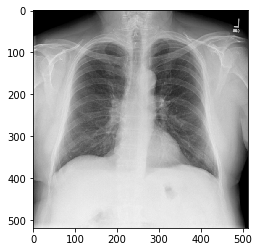

Greedy: the lungs are clear. there is no focal airspace consolidation. no pleural effusion or pneumothorax. heart size is within normal limits. degenerative changes of the thoracic spine.
Original: ['startseq the heart pulmonary xxxx and mediastinum are within normal limits. there is no pleural effusion or pneumothorax. there is no focal air space opacity to suggest a pneumonia. there are mild degenerative changes of the spine. endseq']


In [84]:
z = 13
z+=1
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,1024))
ind = indication_sent[pic.split('.')[0]]
print("Indications:",ind)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image,ind))
print("Original:", first_sent[pic.split('.')[0]])

In [85]:
import warnings
warnings.filterwarnings("ignore")

In [82]:
#predicts the BLUE Score for the generated report
Predictions = dict()
GroundTruths = dict()
test_scores = []
n = len(encoding_test)
start = time()
for z in range(n): # iterate through all the test images
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,1024)) # get the test image encoding
  imgName = pic.split('.')[0]
  if imgName in indication_sent:
    ind = indication_sent[imgName] # get the indication for that image
    if imgName in first_sent:
      references = first_sent[pic.split('.')[0]] # Get the reference sentences
      predicted = greedySearch(image,ind) # get the predicted text output
      references = references[0].replace('startseq ',"")
      references = references.replace('endseq',"")
      score = CalculateBLUEScore(predicted,references)#calculated the blue score.
      test_scores.append(score)
overAllScore = sum(test_scores)/len(test_scores) # average the score for all the predictions.
print(overAllScore)
print("No Of Images = ", len(test_scores))
print("Time taken in seconds =", time()-start)

0.5308943029802263
No Of Images =  354
Time taken in seconds = 1876.3659205436707


In [88]:
def CalculateBLUEScore(predicted, Reference):
  """
        **Calculates the BLUE score**
        
        This function will calculate the BLUE score for the predicted sentence on comparision with reference sentence.
        The Predicted paragraph is split into multiple sentences and each sentence in predicted paragraph is compared 
        against the reference sentences and score is obtained.
        
        :param predicted: Predicted text report
        :type predicted: string
        :param Reference: Reference text report
        :type Reference: string
        :return: BLUE score
        
        - Example::

            reference = [['this', 'is', 'small', 'test']]
            candidate = ['this', 'is', 'a', 'test']
            score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
            print(score)
            
        - Expected Success Response::

            0.75
    
  """
  pred_sents = predicted.split('.')
  actual_sents = Reference.split('.')
  pred_final = []
  actual_final = []
  pred_scores = []

  for sent in pred_sents:
    cur_list = sent.split(' ')
    cur_list = [word for word in cur_list if word]
    pred_final.append(cur_list)
    pred_final = [item for item in pred_final if item]
  
  for sent in actual_sents:
    cur_list = sent.split(' ')
    cur_list = [word for word in cur_list if word]
    actual_final.append(cur_list)
    actual_final = [item for item in actual_final if item]

  for pred_sent in pred_final:
    pred_scores.append(sentence_bleu(actual_final, pred_sent,  weights=(1,0,0,0)))
  avgScore = sum(pred_scores)/len(pred_scores)
  return avgScore

In [90]:
def beam_search_predictions(photo, indication,beam_index = 3):
    """
        **Provides the generated text report for a given image feature, indication and beam_index**
        
        This function take image feature and indication as input and sequencialy constructs the text output by calling
        predict on the model. The model returns the conditional probablities of all the words in vocabulary and 
        we sort the words based on probablity and pic the group of maximum probable words indicated by beam index, 
        append it to the next input sequence. This sequence is again presented to the model for predicting the next word.
        
        :param photo: input image
        :type photo: array
        :param indication: input image
        :type indication: array
        :param beam_index: indicates how many words has to be grouped
        :type beam_index: int
        :return: Predicted text sentences.
        :type: string
        
        - Example::

            print(beam_search_predictions(image,ind))
            
        - Expected Success Response::

            the lungs are clear. there is no focal airspace consolidation. no pleural effusion or pneumothorax. 
            the heart and mediastinum are within normal limits. xxxx are unremarkable.
    
    """
    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    indicationSeq = [indicationWordtoix[word] for word in indication.split(' ') if word in indicationWordtoix]
    indicationSeq = pad_sequences([indicationSeq], maxlen=max_Indication_length)
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[photo]
            #preds = model.predict([np.array([e]), np.array(par_caps)])
            preds = newModel.predict([np.array([e]),indicationSeq,np.array(par_caps)], verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

CXR621_IM-2203-1001.png
Indications: xxxx year old with xxxx and occasional xxxx for 2 weeks.


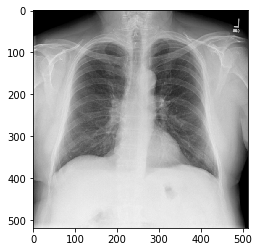

Beam Search: the lungs are clear. there is no focal airspace consolidation. no pleural effusion or pneumothorax. the heart and mediastinum are within normal limits. xxxx are unremarkable.
Original: ['startseq the heart pulmonary xxxx and mediastinum are within normal limits. there is no pleural effusion or pneumothorax. there is no focal air space opacity to suggest a pneumonia. there are mild degenerative changes of the spine. endseq']


In [91]:
z = 13
z+=1
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,1024))
ind = indication_sent[pic.split('.')[0]]
print("Indications:",ind)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Beam Search:",beam_search_predictions(pic,ind))
print("Original:", first_sent[pic.split('.')[0]])

In [77]:
Predictions = dict()
GroundTruths = dict()
test_scores = []
n = len(encoding_test)
start = time()
for z in range(n):
  print("Current Iteration:",z)
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,1024))
  imgName = pic.split('.')[0]
  if imgName in indication_sent:
    ind = indication_sent[imgName]
    if imgName in first_sent:
      references = first_sent[pic.split('.')[0]]
      predicted = beam_search_predictions(pic,ind)
      references = references[0].replace('startseq ',"")
      references = references.replace('endseq',"")
      score = CalculateBLUEScore(predicted,references)
      test_scores.append(score)
overAllScore = sum(test_scores)/len(test_scores)
print(overAllScore)
print("No Of Images = ", len(test_scores))
print("Time taken in seconds =", time()-start)

Current Iteration: 0
Current Iteration: 1
Current Iteration: 2
Current Iteration: 3
Current Iteration: 4
Current Iteration: 5
Current Iteration: 6
Current Iteration: 7
Current Iteration: 8
Current Iteration: 9
Current Iteration: 10
Current Iteration: 11
Current Iteration: 12
Current Iteration: 13
Current Iteration: 14
Current Iteration: 15
Current Iteration: 16
Current Iteration: 17
Current Iteration: 18
Current Iteration: 19
Current Iteration: 20
Current Iteration: 21
Current Iteration: 22
Current Iteration: 23
Current Iteration: 24
Current Iteration: 25
Current Iteration: 26
Current Iteration: 27
Current Iteration: 28
Current Iteration: 29
Current Iteration: 30
Current Iteration: 31
Current Iteration: 32
Current Iteration: 33
Current Iteration: 34
Current Iteration: 35
Current Iteration: 36
Current Iteration: 37
Current Iteration: 38
Current Iteration: 39
Current Iteration: 40
Current Iteration: 41
Current Iteration: 42
Current Iteration: 43
Current Iteration: 44
Current Iteration: 4

Current Iteration: 362
Current Iteration: 363
Current Iteration: 364
Current Iteration: 365
Current Iteration: 366
Current Iteration: 367
Current Iteration: 368
Current Iteration: 369
Current Iteration: 370
Current Iteration: 371
Current Iteration: 372
Current Iteration: 373
Current Iteration: 374
Current Iteration: 375
Current Iteration: 376
Current Iteration: 377
Current Iteration: 378
Current Iteration: 379
Current Iteration: 380
Current Iteration: 381
Current Iteration: 382
Current Iteration: 383
Current Iteration: 384
Current Iteration: 385
Current Iteration: 386
Current Iteration: 387
Current Iteration: 388
Current Iteration: 389
Current Iteration: 390
Current Iteration: 391
Current Iteration: 392
Current Iteration: 393
Current Iteration: 394
Current Iteration: 395
Current Iteration: 396
Current Iteration: 397
Current Iteration: 398
Current Iteration: 399
Current Iteration: 400
Current Iteration: 401
Current Iteration: 402
Current Iteration: 403
Current Iteration: 404
Current Ite

Current Iteration: 720
Current Iteration: 721
Current Iteration: 722
Current Iteration: 723
Current Iteration: 724
Current Iteration: 725
Current Iteration: 726
Current Iteration: 727
0.47954754821151174
No Of Images =  354
Time taken in seconds = 10270.106913805008
